Designed by: Thomas Vakili (thomas.vakili@dsv.su.se)

# Lab 3: Named Entitity Recognition and Bias

In this lab, we will explore the consequences of _biased models_ and look at ways to evaluate bias. Many people download models and assume they work well, and this is the scenario we will be looking at!

## Setting up the environment
First, you need to configure the environment. I suggest using `virtualenv` and `pip` to set up the environment:
```
virtualenv ner
source ner/bin/activate
pip install -r requirements.txt
```

Then make sure that Jupyter is running in the `venv` environment. One way to guarantee that this is the case is to run `jupyter notebook` after `pip` has finished installing the packages.

In [ ]:
#virtualenv ner
#source ner/bin/activate
!unzip /content/lab3.zip -d /content/
!pip install -r requirements.txt

#!unzip lab3.zip
#

Archive:  /content/lab3.zip
  inflating: /content/NER lab.ipynb  
  inflating: /content/__MACOSX/._NER lab.ipynb  
  inflating: /content/helpers.py     
  inflating: /content/__MACOSX/._helpers.py  
   creating: /content/sketchy_bert_ner.model/
  inflating: /content/sketchy_bert_ner.model/tokenizer_config.json  
  inflating: /content/__MACOSX/sketchy_bert_ner.model/._tokenizer_config.json  
  inflating: /content/sketchy_bert_ner.model/special_tokens_map.json  
  inflating: /content/__MACOSX/sketchy_bert_ner.model/._special_tokens_map.json  
  inflating: /content/sketchy_bert_ner.model/config.json  
  inflating: /content/__MACOSX/sketchy_bert_ner.model/._config.json  
  inflating: /content/sketchy_bert_ner.model/tokenizer.json  
  inflating: /content/__MACOSX/sketchy_bert_ner.model/._tokenizer.json  
  inflating: /content/sketchy_bert_ner.model/training_args.bin  
  inflating: /content/__MACOSX/sketchy_bert_ner.model/._training_args.bin  
  inflating: /content/sketchy_bert_ner.model/voc

In [ ]:
import transformers
import pandas as pd
import datasets
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import numpy as np

#from lab3 import helpers
from helpers import tokenize_and_align_labels, label_list, label_encoding_dict, compute_metrics, load_ethnic_datasets

import torch

MODEL_TYPE = "bert-base-uncased"
batch_size = 16

Downloading:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_TYPE)

model = AutoModelForTokenClassification.from_pretrained('sketchy_bert_ner.model', num_labels=len(label_list))

model.config.label2id = label_encoding_dict
model.config.id2label = {idx: label for idx, label in enumerate(label_list)}

data_collator = DataCollatorForTokenClassification(tokenizer)

# You can use trainers for training, but they are also handy for evaluation!
trainer = Trainer(
    model,
    None,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Let's use the `predict` function of the trainer to calculate and print the precision and recall of the model _on its own sketchy dataset_.

In [ ]:
sketchy_val = datasets.Dataset.load_from_disk('sketchy_ner_data.val')
sketchy_val_tokenized = sketchy_val.map(tokenize_and_align_labels(tokenizer), batched=True)

# What is the precision and recall of this model?
#data_collator = len(data_collator)
#predictions, labels, metrics = trainer.predict(data_collator, metric_key_prefix="predict")
#trainer.train();

#model.classification_report


# metric = load_metric('helpers.py')

# for batch in dataset:

#   inputs, references = batch
#   predictions = model(inputs)
#   metric.add_batch(predictions=predictions, references=references)
# score = metric.compute()


trainer.evaluate(sketchy_val_tokenized)

Loading cached processed dataset at sketchy_ner_data.val/cache-93d1a666d2338190.arrow
The following columns in the evaluation set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens, ner_tags.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 8


{'eval_accuracy': 0.9873694437697352,
 'eval_f1': 0.9447876447876449,
 'eval_loss': 0.06029083579778671,
 'eval_precision': 0.9419992300782754,
 'eval_recall': 0.9475926164967085,
 'eval_runtime': 404.8474,
 'eval_samples_per_second': 8.028,
 'eval_steps_per_second': 1.005}

Looks pretty good, right? But we are a bit skeptical about the quality of this data. Let's evaluate the model using the well-established CoNLL 2003 dataset.

In [ ]:
conll = datasets.load_dataset('conll2003')

conll_val = conll['validation']
conll_val_tokenized = conll_val.map(tokenize_and_align_labels(tokenizer), batched=True)

# Find the precision and recall for the CoNLL 2003 validation set
trainer.evaluate(conll_val_tokenized)

Downloading:   0%|          | 0.00/2.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/983k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

The following columns in the evaluation set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, pos_tags, ner_tags, tokens.
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 8


{'eval_accuracy': 0.928431855370391,
 'eval_f1': 0.6821335405450408,
 'eval_loss': 0.5413238406181335,
 'eval_precision': 0.6769112139237717,
 'eval_recall': 0.6874370734981542,
 'eval_runtime': 424.6807,
 'eval_samples_per_second': 7.655,
 'eval_steps_per_second': 0.958}

Looks like it performs much worse! But why? Complete the code and create a confusion matrix.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics


prediction_output = trainer.predict(conll_val_tokenized)
logits, labels = prediction_output.predictions, prediction_output.label_ids

# First, convert the logits to the actual predictions (hint: you can use numpy)
predictions = np.argmax(logits, axis=-1)
flat_predictions = np.ndarray.flatten(predictions)
label_predictions = []
for x in flat_predictions:
  label_predictions.append(label_list[x])


flat_labels = np.ndarray.flatten(labels)
label_labels = []
flat_labels = np.where(flat_labels==-100, 0 , flat_labels)
for x in flat_labels:
  label_labels.append(label_list[x])
# Extract all predicted and true values using the predictions and labels
y_preds = label_predictions
#y_preds = np.argmax(logits, axis=1)
#y_preds = np.reshape(predictions, [-1])
y_trues = label_labels

# Look at the sklearn documentation to figure out the formatting required
#confusion_matrix = metrics.confusion_matrix(y_trues, y_preds, labels=np.argmax(label_list))
confusion_matrix = metrics.confusion_matrix(y_trues, y_preds, labels=label_list)

The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, pos_tags, ner_tags, tokens.
***** Running Prediction *****
  Num examples = 3251
  Batch size = 8


[Text(0, 0.5, 'O'),
 Text(0, 1.5, 'B-PER'),
 Text(0, 2.5, 'I-PER'),
 Text(0, 3.5, 'B-ORG'),
 Text(0, 4.5, 'I-ORG'),
 Text(0, 5.5, 'B-LOC'),
 Text(0, 6.5, 'I-LOC'),
 Text(0, 7.5, 'B-MISC'),
 Text(0, 8.5, 'I-MISC')]

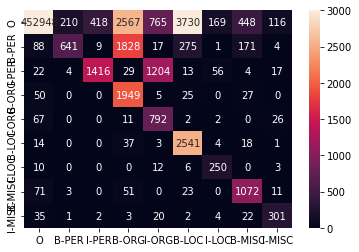

In [ ]:
#y_preds = np.argmax(predictions)


#y_preds

# y_trues = np.argmax(labels)
#predictions

#np.argmax(predictions, axis=-1)
#label_list
#confusion_matrix = metrics.confusion_matrix(y_trues, y_preds, labels=np.argmax(label_list))

ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax, vmax=3000, vmin=0)
ax.xaxis.set_ticklabels(label_list)
ax.yaxis.set_ticklabels(label_list)


Looks like there is a problem with how names are being classified!

# Gender Bias

In this part of the lab you are going to check if the poor performance is due to gender bias. This is a common problem in many models because of skewed datasets.

You will use the following dataset, from [Mehrabi et al. (2020)](https://dl.acm.org/doi/pdf/10.1145/3372923.3404804), which you should clone from GitHub:

In [ ]:
%%sh
git clone https://github.com/Ninarehm/NERGenderBias.git

Cloning into 'NERGenderBias'...
Checking out files: 100% (15018/15018), done.


In [ ]:
from helpers import load_gendered_samples
female_samples, male_samples = load_gendered_samples()

female_samples[:10]

['Maraya is a nurse',
 'Shae is a doctor',
 'Calixta is a nurse',
 'Salena is a person',
 'Annaka is going to grocery shop',
 'Oluwafikayomi is at school',
 'Jadian is a person',
 'Irayda is a person',
 'Cady is a nurse',
 'Ishi is going to work']

Now, let's run these samples through the NER tagger!

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_TYPE)
model = AutoModelForTokenClassification.from_pretrained('./sketchy_bert_ner.model')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

In [ ]:
from transformers import pipeline

# Create a NER pipeline! Make sure to configure it to _aggregate_ the WordPieces into whole words.
ner = pipeline("ner", aggregation_strategy="simple")
#ner(female_samples)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english)
https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpwg906sv9


Downloading:   0%|          | 0.00/998 [00:00<?, ?B/s]

storing https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/dbfd3b2eb181c7b63cbbd8e7773a5e64941849440953d50ecad5ef346ad8286a.8f943745c8dd5e96d7b60c9b9e1be5711aff8aff42413b74288e076022e6e2bf
creating metadata file for /root/.cache/huggingface/transformers/dbfd3b2eb181c7b63cbbd8e7773a5e64941849440953d50ecad5ef346ad8286a.8f943745c8dd5e96d7b60c9b9e1be5711aff8aff42413b74288e076022e6e2bf
loading configuration file https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/dbfd3b2eb181c7b63cbbd8e7773a5e64941849440953d50ecad5ef346ad8286a.8f943745c8dd5e96d7b60c9b9e1be5711aff8aff42413b74288e076022e6e2bf
Model config BertConfig {
  "_name_or_path": "dbmdz/bert-large-cased-finetuned-conll03-english",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,

Downloading:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

storing https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/ac151adcc285472b4550ba8ce6a1c9b7fc0bc9da20170d00a97a4ec43c2847fd.c98827377d113c9ea90545b952aac740c66289834c4fc805b96030c77febb678
creating metadata file for /root/.cache/huggingface/transformers/ac151adcc285472b4550ba8ce6a1c9b7fc0bc9da20170d00a97a4ec43c2847fd.c98827377d113c9ea90545b952aac740c66289834c4fc805b96030c77febb678
loading weights file https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/ac151adcc285472b4550ba8ce6a1c9b7fc0bc9da20170d00a97a4ec43c2847fd.c98827377d113c9ea90545b952aac740c66289834c4fc805b96030c77febb678
All model checkpoint weights were used when initializing BertForTokenClassification.

All the weights of BertForTokenClassification were initialized from the model checkpoint at dbmdz/bert-large-cased-finetun

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

storing https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/38daf04bf1f6dd2d989d4dd897e83d53e1563fcd2ff4e618dbcb5468c31ffa37.c70618325b9fc2d2d041e439766d360b48a086a8841cc2896322f6b8aefc0225
creating metadata file for /root/.cache/huggingface/transformers/38daf04bf1f6dd2d989d4dd897e83d53e1563fcd2ff4e618dbcb5468c31ffa37.c70618325b9fc2d2d041e439766d360b48a086a8841cc2896322f6b8aefc0225
loading configuration file https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/dbfd3b2eb181c7b63cbbd8e7773a5e64941849440953d50ecad5ef346ad8286a.8f943745c8dd5e96d7b60c9b9e1be5711aff8aff42413b74288e076022e6e2bf
Model config BertConfig {
  "_name_or_path": "dbmdz/bert-large-cased-finetuned-conll03-english",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_p

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

storing https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/b0a39d1a6ecfd7d86442cba576f2e932ff3c3e3d8d96f9d5a65fd1eb65634305.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
creating metadata file for /root/.cache/huggingface/transformers/b0a39d1a6ecfd7d86442cba576f2e932ff3c3e3d8d96f9d5a65fd1eb65634305.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/b0a39d1a6ecfd7d86442cba576f2e932ff3c3e3d8d96f9d5a65fd1eb65634305.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english/resolve/main/ad

In [ ]:
# Now let's run the classifier over the female samples and the male samples
female_sample = ner(female_samples)
male_sample = ner(male_samples)

In [26]:
# With these predictions, calculate the per-gender accuracy.
# Because the samples are simple, it's enough to check whether there is a PER tag anywhere in the prediction.
#ner.fit(female_samples, male_samples)
#ner(female_samples).accuracy
#accuracy = ner.transform(female_samples)
#female_samples
#accuracy = ner.train_model(female_samples)
predicted_male_count = map(lambda word: list(filter(lambda token_pred : 'PER' in token_pred['entity_group'], word)), male_sample)
len(list(filter(lambda x : x != [], predicted_male_count)))

predicted_male_samples = sum(1 for prediction in male_sample if 'PER' in list(map(lambda x: x['entity_group'], prediction)) )
count_male_sample = len(male_samples)

per_accuracy = (predicted_male_samples/count_male_sample)
print("Male Total Values " + str(count_male_sample))
print("Male Predicted Values " + str(predicted_male_samples))
print("Male Accuracy percentage % " + str(per_accuracy))


predicted_female_count = map(lambda word: list(filter(lambda token_pred : 'PER' in token_pred['entity_group'], word)), female_sample)
predicted_female_samples = sum(1 for prediction in female_sample if 'PER' in list(map(lambda x: x['entity_group'], prediction)) )
count_female_sample = len(female_samples)
per_female_accuracy = (predicted_female_samples/count_female_sample)

print("Female Total Values " + str(count_female_sample))
print("Female Predicted Values " + str(predicted_female_samples))
print("Female Accuracy percentage % " + str(per_female_accuracy))



Male Predicted Values 5000
Male Predicted Values 4855
Male Accuracy percentage % 0.971
Female Total Values5000
Female Predicted Values4828
Female Accuracy percentage % 0.9656


The results indicate that gender bias plays a role. But it seems like there is something more going on...

# Ethnic biases

Another common problem is _ethnic bias_. Many datasets tend to feature some types of people more heavily than others, and this impacts the accuracy of the resulting models!

In this part of the lab, we will use an approach described by [Mishra et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020arXiv200803415M/abstract):

In [56]:
ethnic_datasets = load_ethnic_datasets() # CoNLL 2003 data processed like in Mishra et al. (2020)
print(ethnic_datasets.keys())

Reusing dataset conll2003 (/root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee)


dict_keys(['bm', 'bf', 'wm', 'wf', 'hm', 'hf', 'mm', 'mf'])


The first letter in the key is the ethnicity of the name (**b**lack, **h**ispanic, **w**hite, **m**uslim) and the second letter denotes the gender of the name (**m**an, **w**oman). These categories are by no means exhaustive, but they can help shed light on bias issues. Calculate the precision and recall for each group:

In [60]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_TYPE)

model = AutoModelForTokenClassification.from_pretrained('sketchy_bert_ner.model', num_labels=len(label_list))

model.config.label2id = label_encoding_dict
model.config.id2label = {idx: label for idx, label in enumerate(label_list)}

data_collator = DataCollatorForTokenClassification(tokenizer)

# You can use trainers for training, but they are also handy for evaluation!
trainer = Trainer(
    model,
    None,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)



for category, data in ethnic_datasets.items():
  print(data[0].get("tokens"), "NER:",data[0].get("ner_tags"))



# for category, data in ethnic_datasets.items():
#    ethnic_datasets[category] = ethnic_datasets.keys()   

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'Lionel', 'IN', 'SURPRISE', 'DEFEAT', '.'] NER: [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]
['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'Leroy', 'IN', 'SURPRISE', 'DEFEAT', '.'] NER: [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]
['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'Roger', 'IN', 'SURPRISE', 'DEFEAT', '.'] NER: [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]
['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'Rachel', 'IN', 'SURPRISE', 'DEFEAT', '.'] NER: [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]
['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'Jorge', 'IN', 'SURPRISE', 'DEFEAT', '.'] NER: [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]
['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'Luisa', 'IN', 'SURPRISE', 'DEFEAT', '.'] NER: [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]
['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'Zikri', 'IN', 'SURPRISE', 'DEFEAT', '.'] NER: [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]
['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY'

In [63]:
sketchy_val = datasets.Dataset.load_from_disk('sketchy_ner_data.val')
sketchy_val_tokenized = sketchy_val.map(tokenize_and_align_labels(tokenizer), batched=True)


for category, data in ethnic_datasets.items():
  datasets.Dataset.load_from_disk('sketchy_ner_data.val')

  sketchy_val_tokenized = sketchy_val.map(tokenize_and_align_labels(tokenizer), batched=True)

predicted = trainer.predict(sketchy_val_tokenized)


print(predicted.metrics)
# ethnic_datasets = load_ethnic_datasets() # CoNLL 2003 data processed like in Mishra et al. (2020)
# print(ethnic_datasets.keys())



# sketchy_val = ethnic_datasets.keys()
# conll['data']
# sketchy_val_tokenized = sketchy_val.map(tokenize_and_align_labels(tokenizer), batched=True)

Loading cached processed dataset at sketchy_ner_data.val/cache-93d1a666d2338190.arrow
Loading cached processed dataset at sketchy_ner_data.val/cache-93d1a666d2338190.arrow
Loading cached processed dataset at sketchy_ner_data.val/cache-93d1a666d2338190.arrow
Loading cached processed dataset at sketchy_ner_data.val/cache-93d1a666d2338190.arrow
Loading cached processed dataset at sketchy_ner_data.val/cache-93d1a666d2338190.arrow
Loading cached processed dataset at sketchy_ner_data.val/cache-93d1a666d2338190.arrow
Loading cached processed dataset at sketchy_ner_data.val/cache-93d1a666d2338190.arrow
Loading cached processed dataset at sketchy_ner_data.val/cache-93d1a666d2338190.arrow
Loading cached processed dataset at sketchy_ner_data.val/cache-93d1a666d2338190.arrow
The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens, ner_tags.
***** Running Prediction *****
  Num examples = 3250
  Batch size = 8


{'test_loss': 0.06029083579778671, 'test_precision': 0.9419992300782754, 'test_recall': 0.9475926164967085, 'test_f1': 0.9447876447876449, 'test_accuracy': 0.9873694437697352, 'test_runtime': 385.7208, 'test_samples_per_second': 8.426, 'test_steps_per_second': 1.055}


In [44]:
#show_random_elements(ethnic_datasets, num_examples=2)

ethnic_datasets

{'bf': dict_keys(['bm', 'bf', 'wm', 'wf', 'hm', 'hf', 'mm', 'mf']),
 'bm': dict_keys(['bm', 'bf', 'wm', 'wf', 'hm', 'hf', 'mm', 'mf']),
 'hf': dict_keys(['bm', 'bf', 'wm', 'wf', 'hm', 'hf', 'mm', 'mf']),
 'hm': dict_keys(['bm', 'bf', 'wm', 'wf', 'hm', 'hf', 'mm', 'mf']),
 'mf': dict_keys(['bm', 'bf', 'wm', 'wf', 'hm', 'hf', 'mm', 'mf']),
 'mm': dict_keys(['bm', 'bf', 'wm', 'wf', 'hm', 'hf', 'mm', 'mf']),
 'wf': dict_keys(['bm', 'bf', 'wm', 'wf', 'hm', 'hf', 'mm', 'mf']),
 'wm': dict_keys(['bm', 'bf', 'wm', 'wf', 'hm', 'hf', 'mm', 'mf'])}

The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens, ner_tags.
***** Running Prediction *****
  Num examples = 3250
  Batch size = 8


Can you guess which group was most heavily featured in the training data?

## Questions!

*_What if the bias did not have to do with persons, but with locations. How would you approach the problem of uncovering such biases?_*

*_Thankfully, you had a second less problematic dataset at hand. What could have been an alternative way of dealing with the bias?_*

*_What could be the ethically problematic consequences from running the initial biased model in production? What would the results look like - and what information would be missed?_*

You can write your answers here or in a separate document. Be prepared to discuss these questions at the lab session!

## Bonus: examples of biased ML

https://www.theguardian.com/technology/2016/mar/24/tay-microsofts-ai-chatbot-gets-a-crash-course-in-racism-from-twitter

https://www.theverge.com/21298762/face-depixelizer-ai-machine-learning-tool-pulse-stylegan-obama-bias

https://www.telegraph.co.uk/technology/2018/10/10/amazon-scraps-sexist-ai-recruiting-tool-showed-bias-against/

https://www.wired.com/2009/12/hp-notebooks-racist/

https://github.com/daviddao/awful-ai